# DS-GA 1003 Course Project Skeleton Code


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### Parse Nation-wide Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Parse data in the state
def parse_national_data(file_path):
    dataFrame = pd.read_csv(file_path)
    cases_nation = dataFrame[['date','positive','recovered','death','positiveIncrease']]
    cases_nation = cases_nation.fillna(0)
    active = cases_nation['positive']-cases_nation['recovered']-cases_nation['death']
    cases_nation = cases_nation.assign(active=list(active))
    cases_nation.to_csv('USA.csv')

In [0]:
file_path = '/content/drive/My Drive/ML final proj/covid19-in-usa/us_covid19_daily.csv'
parse_national_data(file_path)

### Parse States Data

In [0]:
# Parse data in each state
def parse_states_data(file_path):
    dataFrame = pd.read_csv(file_path)
    col_list = ['date','state','positive','recovered','death','positiveIncrease']

    def get_cases(dataFrame,col_list):
        cases = dataFrame[col_list]
        return cases

    def get_states(cases):
        states = set(cases['state'])
        sorted(states, key= lambda x: x.lower())
        return states

    def construct_csv(states,cases):
        for state in states:
            state_case = cases[cases['state'] == state]
            state_case.reset_index(drop=True,inplace=True)
            state_case = state_case.fillna(0)
            active = state_case['positive']-state_case['recovered']-state_case['death']
            state_case = state_case.assign(active=list(active))
            state_case.to_csv('{state_name}.csv'.format(state_name = state),
                            index=True)
            
    cases_states = get_cases(dataFrame,col_list)
    states = get_states(cases_states)
    construct_csv(states,cases_states)

In [0]:
file_path = '/content/drive/My Drive/ML final proj/covid19-in-usa/us_states_covid19_daily.csv'
parse_states_data(file_path)

### data visualization

In [0]:
# convret '2020xxxx' to 'year-mo-dy'
def convert_date(date):
    date_time = []
    for d in date:
        year = str(d)[0:4]
        month = str(d)[4:6]
        day = str(d)[6:8]
        time = datetime(year=int(year), month=int(month), day=int(day))
        date_time.append(time)
    return date_time

# data visualization
def visualization(state):
    file_path = '{}.csv'.format(state)
    data = pd.read_csv(file_path)

    date = data['date']
    positive = data['positive']
    active = data['active']
    increase = data['positiveIncrease']

    date_time = convert_date(date)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot()
    ax1.plot(date_time, positive, 'xkcd:orange')
    ax1.plot(date_time, active, 'xkcd:maroon')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('cases')
    ax1.legend(['positive','active'])
    ax1.grid(True)
    ax1.set_title(state)

    ax2 = ax1.twinx()
    ax2.plot(date_time, increase, '.',color='xkcd:violet')
    ax2.set_ylabel('increase')
    ax2.legend(['incerase'],loc='lower right')

    fig.tight_layout()
    plt.show()

NY


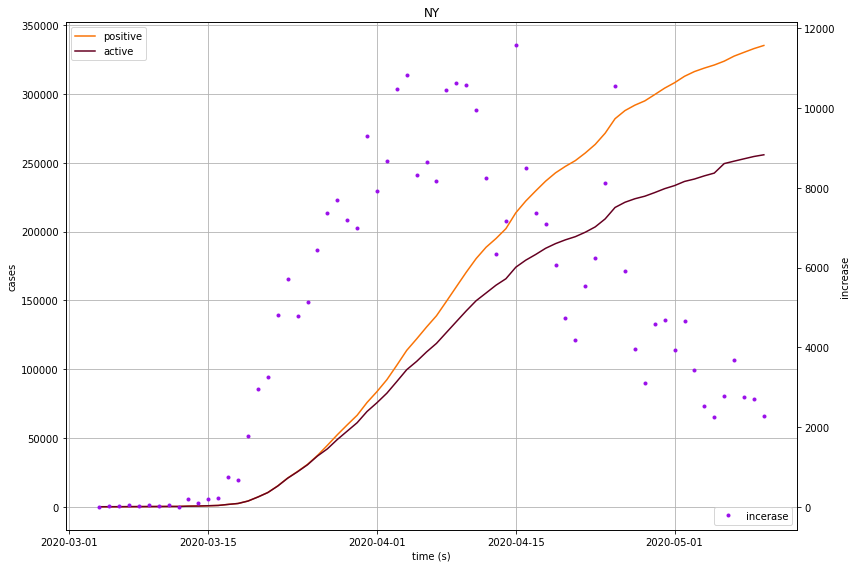

In [15]:
state = input()
visualization(state)

### Fetch ngram labels from data


In [0]:
!pip install pytrends
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends
!pip install nltk
!pip install textblob
!pip install tqdm

  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14261 sha256=220ff74b362404df9eded0e1ce098fe6626d293730572ca0871493b972fdd8a0
  Stored in directory: /root/.cache/pip/wheels/64/ae/af/51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends
  Cloning https://github.com/GeneralMills/pytrends to /tmp/pip-req-build-m6v36ev_
  Running command git clone -q https://github.com/GeneralMills/pytrends /tmp/pip-req-build-m6v36ev_
  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14948 sha256=e0e29d7f486d7a336ec1a392245fe2ad43230e2ed0930709bee9c47e3abae25a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0oh0jyii/wheels/f6/49/f7/a4785ff2079f1cc793186a60d40863c5d4ee9863e2b315a0bd
Successfully built pytrends


In [0]:
import os
import numpy as np
import pandas as pd
import json
import nltk
import time
from tqdm import tqdm
from textblob import TextBlob
from pytrends.request import TrendReq

In [0]:
# TERM_PATH = "./frequent_terms.csv"
# BIGRAM_PATH = "./frequent_bigrams.csv"
# TRIGRAM_PATH = "./frequent_trigrams.csv"
TERM_PATH = "/content/drive/My Drive/ML final proj/frequent_terms.csv"
BIGRAM_PATH = "/content/drive/My Drive/ML final proj/frequent_bigrams.csv"
TRIGRAM_PATH = "/content/drive/My Drive/ML final proj/frequent_trigrams.csv"

In [0]:
num_features = 50

terms_data = pd.read_csv(TERM_PATH)
terms = list(terms_data['term'])
counts = list(terms_data['counts'])
result1 = pd.DataFrame(np.array([terms, counts]).T, columns=['keyword', 'count'])[:num_features]

bigram_data = pd.read_csv(BIGRAM_PATH)
bigrams = list(bigram_data['gram'])
counts = list(bigram_data['counts'])
result2 = pd.DataFrame(np.array([bigrams, counts]).T, columns=['keyword', 'count'])[:num_features]

trigram_data = pd.read_csv(TRIGRAM_PATH)
trigrams = list(trigram_data['gram'])
counts = list(trigram_data['counts'])
result3 = pd.DataFrame(np.array([trigrams, counts]).T, columns=['keyword', 'count'])[:num_features]

keywords = pd.concat([result1, result2, result3], ignore_index=True)
# keywords = pd.concat([result2, result3], ignore_index=True)

In [0]:
keywords

,keyword,count
0,coronavirus,28120854
1,covid19,8630451
2,covid,8171888
3,19,7903151
4,nan,3888201
...,...,...
145,penyebaran covid 19,36072
146,covid 19 testing,35640
147,deliver copy officials,35454
148,copy officials last,35452


In [0]:
ptr = TrendReq(hl='en-US', tz=300, retries=3, backoff_factor=10) # tz: time-zone offset, 300 for EST

In [0]:
kw_list = list(keywords["keyword"])[0]
ptr.build_payload([kw_list], cat=0, timeframe='2020-01-21 2020-05-1', geo='', gprop='')
result = ptr.interest_over_time().drop(columns=['isPartial'])

In [0]:
t = tqdm(list(keywords["keyword"])[1:])
for kw in t:
    t.set_description(desc="Fetching...")
    del(ptr)
    time.sleep(0.5)
    ptr = TrendReq(hl='en-US', tz=300, retries=3, backoff_factor=10) # tz: time-zone offset, 300 for EST
    ptr.build_payload([kw], cat=0, timeframe='2020-01-21 2020-05-1', geo='', gprop='')
    try:
        result = pd.concat([result, ptr.interest_over_time().drop(columns='isPartial')], axis=1)
    except KeyError:
        result = pd.concat([result, ptr.interest_over_time()], axis=1)

In [0]:
result

In [0]:
result.to_csv("./ngrams_by_date_90.csv")

### Training & Validation Data

In [0]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

In [0]:
# ngram_n = pd.read_csv("/content/drive/My Drive/ML final proj/keywords_30_US.csv")
# ngram_n.head(5)

In [0]:
# df_matrix = ngram_n.drop(['date'], axis=1,inplace=False).to_numpy()
# print(df_matrix)

In [0]:
# ###
# avg_date = 7

In [0]:
# # Average with date
# def avg_data_sample(dataFrame, avg_date=7):
#     df_matrix = dataFrame.drop(['date'], axis=1,inplace=False).to_numpy()

#     d_avg = np.zeros((df_matrix.shape[0]-avg_date,df_matrix.shape[1]))
#     for i in range(len(d_avg)):
#         d_avg[i] = np.mean(df_matrix[i:i+avg_date],axis=0)
#     return d_avg

In [0]:
# # Concatenate with date
# def concat_data_sample(dataFrame, concat_date=7):
#     df_matrix = dataFrame.drop(['date'], axis=1,inplace=False).to_numpy()

#     d_concat =  np.zeros((df_matrix.shape[0]-avg_date,df_matrix.shape[1]*concat_date))
#     for i in range(len(d_concat)):
#         d_concat[i] = np.ndarray.flatten(df_matrix[i:i+concat_date])
#     return d_concat

In [0]:
# df_concat = concat_data_sample(ngram_n, concat_date=3)
# print(df_concat)

In [0]:
# df_matrix = avg_data_sample(ngram_n, avg_date=avg_date)
# print(df_matrix)

In [0]:
# cases_data = pd.read_csv('USA.csv')
# cases_data.head(10)

In [0]:
# def avg_target_labels(dataFrame, tag=None, avg_date=7, delay_date=7):
#     if tag is None:
#         tag = 'positiveIncrease'
#     positive = dataFrame[tag]

#     d_avg_rev = np.zeros((positive.shape[0]-avg_date))
#     for i in range(len(d_avg_rev)):
#         d_avg_rev[i] = np.mean(positive[i:i+avg_date])

#     d_avg = np.flipud(d_avg_rev)[1:]
#     # Delay by date
#     d_avg = d_avg[delay_date:]
#     return d_avg

In [0]:
# # z-score Standrization
# # Standardrize mean-matrix
# train_matrix = scipy.stats.zscore(df_matrix, axis=1)
# # Standardrize concat-matrix
# # train_matrix = scipy.stats.zscore(df_concat, axis=1)

# # labels
# d_avg = avg_target_labels(dataFrame=cases_data, avg_date=avg_date)

In [0]:
class parse_data:

    def __init__(self, avg_date=7, concat_date=7, delay_date=7):
        self.avg_date = avg_date
        self.concat_date = concat_date
        self.delay_date = delay_date

    def parse_file(self,keywords_path, cases_path):
        self.keywords = pd.read_csv(keywords_path)
        self.cases = pd.read_csv(cases_path)
        return self

    # Average with date
    def process_data_sample(self, process='mean'):
        matrix = self.keywords.drop(['date'], axis=1,inplace=False).to_numpy()

        if process == 'mean':
            avg_mtx = np.zeros((matrix.shape[0]-self.avg_date,matrix.shape[1]))
            for i in range(len(d_avg)):
                avg_mtx[i] = np.mean(matrix[i:i+self.avg_date],axis=0)
            # Standardrize mean-matrix
            sample_matrix = scipy.stats.zscore(avg_mtx, axis=1)
        elif process == 'concat':
            concat_mtx =  np.zeros((matrix.shape[0]-self.concat_date,matrix.shape[1]*self.concat_date))
            for i in range(len(d_concat)):
                concat_mtx[i] = np.ndarray.flatten(df_matrix[i:i+self.concat_date])
            sample_matrix = scipy.stats.zscore(concat_mtx, axis=1)
        return sample_matrix

    def process_labels(self, tag=None):
        if tag is None:
            tag = 'positiveIncrease'
        labels = self.cases[tag]
        avg_array_rev = np.zeros((labels.shape[0]-self.avg_date))
        for i in range(len(avg_array_rev)):
            avg_array_rev[i] = np.mean(labels[i:i+self.avg_date])
        label_array = np.flipud(avg_array_rev)[self.delay_date+1:]
        return label_array


In [0]:
# file_parser
parser = parse_data()
parser.parse_file(keywords_path="/content/drive/My Drive/ML final proj/keywords_30_US.csv",cases_path='USA.csv')
d_avg = parser.process_labels()
train_matrix = parser.process_data_sample()

# Train test data split (test data is the latest data theoretically)
X_train, X_test, y_train, y_test = train_test_split(train_matrix[train_matrix.shape[0]-d_avg.shape[0]:], 
                                                    d_avg, test_size=0.15, shuffle=False) 

In [566]:
# Lasso feature selection
EN_reg = ElasticNet(alpha=1,l1_ratio=1.0,max_iter=15000)
EN_reg.fit(X_train,y_train)

pred_ELN = EN_reg.predict(X_test)
diff = y_test-pred_ELN
print(np.mean(abs(diff)))
print(EN_reg.score(X_test,y_test))
print(EN_reg.coef_)

3603.312271786852
-6.333771063948816
[-4358.18299689 -5051.89847477 13738.73745429    -0.
 -3344.48804652 11004.26341285 -3818.5656024   -152.60082569
     0.           414.24451376     0.           128.04021609
   -51.67064552 -2887.77975861     0.         -2090.54939646
   597.29701418     0.            -0.             0.
  2756.97113861  4059.51611123  -890.84355443 -2068.9813699
  1681.45944046 -3857.67037492   658.14644224]


In [567]:
# MLP Neural Network model
MLP_regressor = MLPRegressor(hidden_layer_sizes=(20,10,5),alpha=1,
                             learning_rate_init=0.01,max_iter=20000,n_iter_no_change=100)
MLP_regressor.fit(X_train,y_train)

pred_MLP = MLP_regressor.predict(X_test)
diff = y_test-pred_MLP
print(np.mean(abs(diff)))
print(MLP_regressor.score(X_train,y_train))
print(MLP_regressor.score(X_test,y_test))

4155.636744398472
0.999993296842053
-9.504675634488978


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'new increase pred in 4/19-5/2')

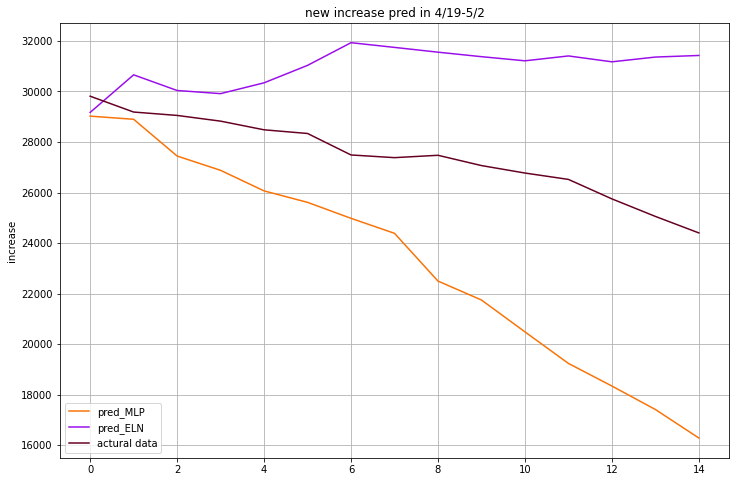

In [568]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
ax1.plot(pred_MLP, 'xkcd:orange')
ax1.plot(pred_ELN, 'xkcd:violet')
ax1.plot(y_test, 'xkcd:maroon')
ax1.set_ylabel('increase')
ax1.legend(['pred_MLP','pred_ELN','actural data'])
ax1.grid(True)
ax1.set_title('new increase pred in 4/19-5/2')